In [1]:
import tqdm
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
import hwutils as util

from collections import namedtuple
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [5]:
import importlib
importlib.reload(util)

<module 'hwutils' from '/home/bogdan/Projects/cs1156x/hwutils.py'>

### Nonlinear transforms

In [3]:
def count_poly_features(degree):
    return 1 if degree == 0 else count_poly_features(degree - 1) + degree + 1

count_poly_features(10) - 1  # not counting constant coordinate

65

### Bias and Variance

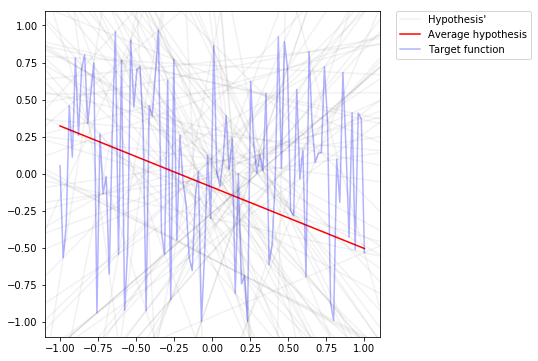

In [4]:
# Cheking if a set of lines fitted on 2 random points produces a linear average hypothesis

INTERVAL = np.array([-1, 1])
N_POINTS = 100
N_HYPOTHESIS = 100

# Simulating some very wiggly function on a plane
X = np.column_stack([np.ones(N_POINTS), np.linspace(*INTERVAL, num=N_POINTS)])
y = np.random.uniform(*INTERVAL, size=N_POINTS)

# Fitting lines by 2 randomly sampled points
def fit_random_line(X_pop, y_pop):
    idx = np.random.choice(N_POINTS, size=2, replace=False)
    X_train, y_train = X_pop[idx], y_pop[idx]
    return util.fit_linear_regression(X_train, y_train)

W = np.array([fit_random_line(X, y) for i in range(N_HYPOTHESIS)])

# Calculating average hypothesis values
y_bar = np.mean(X@W.T, axis=1)


# Plotting
plt.figure(figsize=(6,6))

figure_bounds = INTERVAL*1.1
plt.xlim(*figure_bounds)
plt.ylim(*figure_bounds)

bound_points = np.column_stack([np.ones(2), figure_bounds])
for y_hat in W@bound_points.T:
    g, = plt.plot(figure_bounds, y_hat, color='gray', alpha=0.1, label="Hypothesis'")
g_bar, = plt.plot(X[:, 1], y_bar, color='red', label='Average hypothesis')
target, = plt.plot(X[:, 1], y, color='blue', alpha=0.3, label='Target function')

plt.legend(handles=[g, g_bar, target], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Regularized Linear Regression

In [6]:
features = ['intensity', 'symmetry']

digits_df = namedtuple(typename='USPSZipCodeDataset', field_names='train test') \
            (*[pd.read_csv(path, delimiter='\s+', header=None, names=['digit']+features)
               for path in ('./data/features.train',
                            './data/features.test')])

labels = ['{}-vs-all'.format(d) for d in range(10)]

for df in digits_df:
    for d, colname in enumerate(labels):
        df[colname] = (df['digit'] == d).apply(lambda x: 1 if x else -1)
    df['1-vs-5'] = df['digit'].apply(lambda x: {1: 1, 5: -1}.get(x))

**Problem 7**

In [29]:
X_train = PolynomialFeatures(1).fit_transform(digits_df.train[features])

results = []
for label in labels[5:]:
    y_train = digits_df.train[label].values
    w_hat = util.fit_linear_regression(X_train, y_train, lambda_=1)
    results.append((label,
                    util.calculate_clf_error(X=X_train, y_true=y_train, w_hat=w_hat)))

pd.DataFrame(results, columns=['Classifier', 'In-sample error']).sort_values('In-sample error')

,Classifier,In-sample error
3,8-vs-all,0.074338
0,5-vs-all,0.076258
4,9-vs-all,0.088328
2,7-vs-all,0.088465
1,6-vs-all,0.091071


**Problem 8**

In [52]:
X_train, X_test = [PolynomialFeatures(2).fit_transform(df[features]) for df in digits_df]

results = []
for label in labels[:5]:
    y_train, y_test = [df[label].values for df in digits_df]
    w_hat = util.fit_linear_regression(X_train, y_train, lambda_=1)
    results.append((label,
                    util.calculate_clf_error(X=X_test, y_true=y_test, w_hat=w_hat)))

pd.DataFrame(results, columns=['Classifier', 'Out-of-sample error']).sort_values('Out-of-sample error')

,Classifier,Out-of-sample error
1,1-vs-all,0.021923
3,3-vs-all,0.082711
2,2-vs-all,0.098655
4,4-vs-all,0.099651
0,0-vs-all,0.106627


**Problem 9**

In [85]:
X_lin_train, X_lin_test, X_pl2_train, X_pl2_test = [PolynomialFeatures(degree).fit_transform(df[features])
                                                    for degree, df in itertools.product([1, 2], digits_df)]

colnames = np.array(['Classifier', 'E_in:lin', 'E_out:lin',
                     'E_in:pl2', 'E_out:pl2', 'E_out:lin/pl2'])

result = []
for label in labels:
    y_train, y_test = [df[label].values for df in digits_df]
    
    w_lin = util.fit_linear_regression(X_lin_train, y_train, lambda_=1)
    w_pl2 = util.fit_linear_regression(X_pl2_train, y_train, lambda_=1)
    
    ein_lin = util.calculate_clf_error(X=X_lin_train, y_true=y_train, w_hat=w_lin)
    ein_pl2 = util.calculate_clf_error(X=X_pl2_train, y_true=y_train, w_hat=w_pl2)
    
    eout_lin = util.calculate_clf_error(X=X_lin_test, y_true=y_test, w_hat=w_lin)
    eout_pl2 = util.calculate_clf_error(X=X_pl2_test, y_true=y_test, w_hat=w_pl2)
    
    result.append((label, ein_lin, eout_lin,
                    ein_pl2, eout_pl2, eout_lin / eout_pl2))

result = pd.DataFrame(data=result, columns=colnames)
result = result.set_index(colnames[0])

In [105]:
result[colnames[[1,3,2,4,5]]]

,E_in:lin,E_in:pl2,E_out:lin,E_out:pl2,E_out:lin/pl2
Classifier,,,,,
0-vs-all,0.109313,0.102318,0.115097,0.106627,1.079439
1-vs-all,0.015224,0.012344,0.022422,0.021923,1.022727
2-vs-all,0.100261,0.100261,0.098655,0.098655,1.000000
3-vs-all,0.090248,0.090248,0.082711,0.082711,1.000000
4-vs-all,0.089425,0.089425,0.099651,0.099651,1.000000
5-vs-all,0.076258,0.076258,0.079721,0.079223,1.006289
6-vs-all,0.091071,0.091071,0.084704,0.084704,1.000000
7-vs-all,0.088465,0.088465,0.073244,0.073244,1.000000
8-vs-all,0.074338,0.074338,0.082711,0.082711,1.000000


**Problem 10**

In [121]:
X_train, X_test = [PolynomialFeatures(2).fit_transform(df.loc[df['1-vs-5'].notnull(), features])
                   for df in digits_df]
y_train, y_test = [df.loc[df['1-vs-5'].notnull(), '1-vs-5'].values
                   for df in digits_df]

colnames = np.array(['Lambda', 'E_in', 'E_out'])

result = []
for lambda_ in [0.01, 1]:
    w_hat = util.fit_linear_regression(X_train, y_train, lambda_)
    
    ein = util.calculate_clf_error(X_train, y_train, w_hat)
    eout = util.calculate_clf_error(X_test, y_test, w_hat)
    
    result.append((lambda_, ein, eout))

result = pd.DataFrame(data=result, columns=colnames)
result = result.set_index(colnames[0])

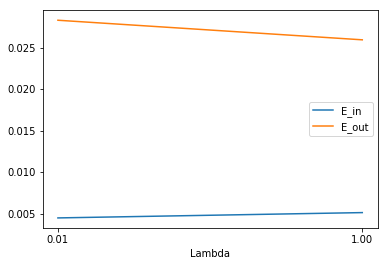

In [125]:
result.plot(xticks=result.index)

###  Support Vector Machines

In [6]:
from sklearn.svm import SVC

In [7]:
X = [[ 1, 0],
     [ 0, 1],
     [ 0,-1],
     [-1, 0],
     [ 0, 2],
     [ 0,-2],
     [-2, 0]]
X = np.array(X)
y = np.array([-1, -1, -1, 1, 1, 1, 1])

In [10]:
SVC(C=1e10, kernel='poly', degree=2).fit(X, y).n_support_.sum()

5

### Radial Basis Functions

In [46]:
from sklearn.cluster import KMeans
from numpy.linalg import norm, inv
from itertools import product

In [67]:
class RegularRBF:
    def __init__(self, n_centroids, gamma):
        self._n_centroids = n_centroids
        self._gamma = gamma
    
    def fit(self, X, y):
        n_points = X.shape[0]

        kmeans = KMeans(n_clusters=self._n_centroids).fit(X)
        centroids = kmeans.cluster_centers_
        
        F = np.empty((n_points, self._n_centroids))
        for n, k in product(range(n_points), range(self._n_centroids)):
            F[n, k] = np.exp(-self._gamma*np.square(norm(X[n] - centroids[k])))
        
        self._centroids = centroids
        self._weights = inv(F.T@F)@F.T@y
        
    @staticmethod
    @np.vectorize
    def _apply(x, weights, centroids):
        sum(w*np.exp(-self._gamma*np.square(norm(x - mu)))
            for w, mu in zip(weights.tolist(), centroids.tolist()))
    
    def predict(self, X):
        return self._apply(X, self._weights, self._centroids)

In [ ]:
def non_linear_separator(x1, x2):
    return x2 - x1 + 0.25*np.sin(np.pi*x1)

X_train, y_train, X_test, y_test = util.get_2D_binary_labeled_datasets(interval=np.array([-1, 1]),
                                                                       labeler=non_linear_separator,
                                                                       train_size=100, test_size=1000)

rbf = RegularRBF(n_centroids=15, gamma=1.5)
rbf.fit(X_train, y_train)
rbf.predict(X_test)